# 네이버 영화리뷰로 감성분석을 해보자! 

- dataset: Naver sentiment movie corus

In [ ]:
import pandas
import konlpy
import gensim
import numpy as np
import re
import tensorflow as tf
import os

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

In [ ]:
#데이터 준비하기

import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/workspace/sentimental_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/workspace/sentimental_classification/data/ratings_test.txt')

#train 데이터 살펴보기
train_data.head()

In [ ]:
#테스트 데이터 살펴보기
test_data.head()

In [ ]:
train_data.info

train / test => 150,000 / 50,000 개

train의 2번처럼 띄어쓰기가 안된 것을 처리하는 방법 / test의 0번,1번처럼 ㅋ이나 한글을 영어타자로 쓴 것을 처리하는 방법에 대해 고민해볼 필요가 있어보인다.

# dataloader 

- 데이터 중복제거
- nan 값 제거
- 한국어 토크나이저
- 불용어 제거
- 사전 구성
- 텍스트 스트링을 인덱스 스트링으로 변환
- train, test의 x,y값과 word2index가 리턴되어야함!

의 역할을 해야한다.

# dataloader 함수에서 각 전처리를 하기위해 확인해야 할 것들.

### 1. 중복제거, nan값 제거

In [ ]:
## 복사해서 사용
train_data_c = train_data.copy() 
test_data_c = test_data.copy() 

# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

In [ ]:
#nan값 확인
print(train_data_c.isnull().values.any())

In [ ]:
#어떤 열에 있는지 개수 확인
print(train_data_c.isnull().sum())

In [ ]:
#nan 값을 가진 샘플 출력
train_data_c.loc[train_data.document.isnull()]

In [ ]:
#null값을 제거하고 잘 제거되었는지 확인 

train_data_c = train_data_c.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data_c.isnull().values.any()) # Null 값이 존재하는지 확인

In [ ]:
# 정규표현식을 활용하여 한글과 공백을 제외하고 모두 제거 + 살펴보기

train_data_c['document'] = train_data_c['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)                 
train_data_c[:5]

In [ ]:
# + 네이버 영화 리뷰는 영어 숫자 특수문자도 있어 이를 제거해줘야한다고 한다.

# 해당 데이터를 null값으로 변경

train_data_c['document'] = train_data_c['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data_c['document'].replace('', np.nan, inplace=True)
print(train_data_c.isnull().sum())

In [ ]:
# 해당 row를 제거해주기

train_data_c = train_data_c.dropna(how = 'any')
print('테스트용 샘플의 개수 : 150,000에서 ',len(train_data_c),'로 변화함.')

In [ ]:
# test data에도 적용

test_data_c.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data_c['document'] = test_data_c['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data_c['document'] = test_data_c['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data_c['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data_c = test_data_c.dropna(how='any') # Null 값 제거
print('테스트용 샘플의 개수 : 50,000에서 ',len(test_data_c),'로 변화함.')

### 2. 불용어 제거 + tokenizer

In [ ]:
from konlpy.tag import Mecab
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
tokenizer = Mecab()

X_train = []
for sentence in train_data_c['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)


In [ ]:
words = np.concatenate(X_train).tolist()


In [ ]:
from collections import Counter

#X_train은 불용어가 제거된 형태소별로 ,로 구분지어 2차원리스트에 담겨져 있다.
words = np.concatenate(X_train).tolist()

#어떤 형태소별로 개수를 세고 10000~4번까지 나오는 형태소만 추출
counter = Counter(words)
counter = counter.most_common(10000-4)

#처음 세 인덱스는 활용안함.
vocab = ['', '', '', ''] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

In [ ]:
len(word_to_index)

# 위의 연습을 토대로 진짜 시작!

## 1) 데이터 준비와 확인


In [6]:
import pandas
import konlpy
import gensim
import numpy as np
import re
import tensorflow as tf
import os

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/workspace/sentimental_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/workspace/sentimental_classification/data/ratings_test.txt')

## 2) dataloader 구성

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words=num_words):
    #df내의 중복 + nan샘플 제거 함수
    def data_preprocessing(df, columns = 'document'):
        df.drop_duplicates(subset = [columns], inplace=True)
        df[columns] = df[columns].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
        df[columns] = df[columns].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
        df[columns].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
        df= df.dropna(how='any') # Null 값 제거
        return df
    
    train_data = data_preprocessing(train_data)
    test_data = data_preprocessing(test_data)
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1 # 패딩용 단어
word_to_index['<UNK>'] = 2 # 문장의 시작지점
word_to_index["<UNUSED>"] = 3

## 3) 모델 구성을 위한 데이터 분석 및 가공

In [4]:
#pad_sequence로 문장의 길이를 통일시키자!

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + x*표준편차)의 분포 확인 
for i in range(2,6):
    max_tokens = np.mean(num_tokens) + i * np.std(num_tokens)
    maxlen = int(max_tokens)
    print('pad_sequences maxlen : ', maxlen)
    print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  13.795479935133466
문장길이 최대 :  83
문장길이 표준편차 :  11.455691867742807
pad_sequences maxlen :  36
전체 문장의 0.933630209271796%가 maxlen 설정값 이내에 포함됩니다. 
pad_sequences maxlen :  48
전체 문장의 0.9725398337151535%가 maxlen 설정값 이내에 포함됩니다. 
pad_sequences maxlen :  59
전체 문장의 0.9971942649746455%가 maxlen 설정값 이내에 포함됩니다. 
pad_sequences maxlen :  71
전체 문장의 0.9998661484208088%가 maxlen 설정값 이내에 포함됩니다. 


maxlen = 48사용해보기

In [7]:
# 데이터셋 패딩 추가

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', #'post' 혹은 'pre'
                                                        maxlen=48)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 'post' 혹은 'pre'
                                                       maxlen=48)

## 4) 모델 구성 및 validation set 구성

In [8]:
# val set

# validation set 50000건 분리
x_val = X_train[:50000]
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_x_train = X_train[50000:]
partial_y_train = y_train[50000:]


In [9]:
# LSTM
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(tf.keras.layers.LSTM(10))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
lstm.add(tf.keras.layers.Dense(10, activation='relu'))
lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


In [10]:
#conv1d

conv = tf.keras.Sequential()
conv.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
conv.add(tf.keras.layers.MaxPooling1D(5))
conv.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
conv.add(tf.keras.layers.GlobalMaxPooling1D())
conv.add(tf.keras.layers.Dense(16, activation='relu'))
conv.add(tf.keras.layers.Dense(4, activation='relu'))
conv.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

In [11]:
#maxpool

maxpool = tf.keras.Sequential()
maxpool.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
maxpool.add(tf.keras.layers.GlobalMaxPooling1D())
maxpool.add(tf.keras.layers.Dense(32, activation='relu'))
maxpool.add(tf.keras.layers.Dense(8, activation='relu'))
maxpool.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

## 5) 모델 훈련 

In [12]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꿔보기. 


lstm.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

historyl = lstm.fit(partial_x_train,
                partial_y_train,
                epochs=epochs,
                batch_size=512,
                validation_data=(x_val, y_val),
                verbose=1)

Epoch 1/20
187/187 [==============================] - 5s 9ms/step - loss: 0.4902 - accuracy: 0.7913 - val_loss: 0.3695 - val_accuracy: 0.8406
Epoch 2/20
187/187 [==============================] - 1s 7ms/step - loss: 0.3436 - accuracy: 0.8548 - val_loss: 0.3551 - val_accuracy: 0.8442
Epoch 3/20
187/187 [==============================] - 1s 7ms/step - loss: 0.3144 - accuracy: 0.8679 - val_loss: 0.3589 - val_accuracy: 0.8423
Epoch 4/20
187/187 [==============================] - 1s 7ms/step - loss: 0.2939 - accuracy: 0.8780 - val_loss: 0.3593 - val_accuracy: 0.8441
Epoch 5/20
187/187 [==============================] - 1s 7ms/step - loss: 0.2739 - accuracy: 0.8868 - val_loss: 0.3654 - val_accuracy: 0.8451
Epoch 6/20
187/187 [==============================] - 1s 7ms/step - loss: 0.2553 - accuracy: 0.8957 - val_loss: 0.3753 - val_accuracy: 0.8453
Epoch 7/20
187/187 [==============================] - 1s 7ms/step - loss: 0.2373 - accuracy: 0.9041 - val_loss: 0.3858 - val_accuracy: 0.8452
Epoch 

In [13]:
conv.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

historyc = conv.fit(partial_x_train,
                partial_y_train,
                epochs=epochs,
                batch_size=512,
                validation_data=(x_val, y_val),
                verbose=1)

Epoch 1/20
187/187 [==============================] - 4s 9ms/step - loss: 0.5668 - accuracy: 0.6736 - val_loss: 0.4334 - val_accuracy: 0.7902
Epoch 2/20
187/187 [==============================] - 1s 7ms/step - loss: 0.3991 - accuracy: 0.8130 - val_loss: 0.4174 - val_accuracy: 0.8003
Epoch 3/20
187/187 [==============================] - 1s 7ms/step - loss: 0.3413 - accuracy: 0.8453 - val_loss: 0.4229 - val_accuracy: 0.8007
Epoch 4/20
187/187 [==============================] - 1s 7ms/step - loss: 0.2784 - accuracy: 0.8776 - val_loss: 0.4523 - val_accuracy: 0.7981
Epoch 5/20
187/187 [==============================] - 1s 7ms/step - loss: 0.2153 - accuracy: 0.9089 - val_loss: 0.5175 - val_accuracy: 0.7924
Epoch 6/20
187/187 [==============================] - 1s 7ms/step - loss: 0.1664 - accuracy: 0.9294 - val_loss: 0.5735 - val_accuracy: 0.7892
Epoch 7/20
187/187 [==============================] - 1s 7ms/step - loss: 0.1320 - accuracy: 0.9425 - val_loss: 0.6478 - val_accuracy: 0.7815
Epoch 

In [14]:
maxpool.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

historym = maxpool.fit(partial_x_train,
                partial_y_train,
                epochs=epochs,
                batch_size=512,
                validation_data=(x_val, y_val),
                verbose=1)

Epoch 1/20
187/187 [==============================] - 1s 5ms/step - loss: 0.5067 - accuracy: 0.7695 - val_loss: 0.3622 - val_accuracy: 0.8383
Epoch 2/20
187/187 [==============================] - 1s 4ms/step - loss: 0.3249 - accuracy: 0.8623 - val_loss: 0.3523 - val_accuracy: 0.8474
Epoch 3/20
187/187 [==============================] - 1s 4ms/step - loss: 0.2712 - accuracy: 0.8897 - val_loss: 0.3599 - val_accuracy: 0.8466
Epoch 4/20
187/187 [==============================] - 1s 4ms/step - loss: 0.2253 - accuracy: 0.9122 - val_loss: 0.3866 - val_accuracy: 0.8447
Epoch 5/20
187/187 [==============================] - 1s 4ms/step - loss: 0.1802 - accuracy: 0.9338 - val_loss: 0.4292 - val_accuracy: 0.8401
Epoch 6/20
187/187 [==============================] - 1s 5ms/step - loss: 0.1374 - accuracy: 0.9526 - val_loss: 0.4798 - val_accuracy: 0.8368
Epoch 7/20
187/187 [==============================] - 1s 4ms/step - loss: 0.1003 - accuracy: 0.9676 - val_loss: 0.5495 - val_accuracy: 0.8310
Epoch 

In [15]:
#모델 평가

results = lstm.evaluate(X_test,y_test, verbose = 2)
print('lstm: ', results)

results = conv.evaluate(X_test,y_test, verbose = 2)
print('conv: ', results)

results = maxpool.evaluate(X_test,y_test, verbose = 2)
print('maxpool: ', results)

1527/1527 - 3s - loss: 0.6950 - accuracy: 0.8248
lstm:  [0.695035994052887, 0.824756383895874]
1527/1527 - 3s - loss: 1.3729 - accuracy: 0.7662
conv:  [1.3729016780853271, 0.7662327289581299]
1527/1527 - 2s - loss: 1.1709 - accuracy: 0.8140
maxpool:  [1.1708875894546509, 0.814030110836029]


In [16]:
# fit()을 하면 history변수에 각 에포크 마다의 항목들이 저장되어있다.

historyl_dict = historyl.history
historyc_dict = historyc.history
historym_dict = historym.history

## 6) 평가지표 그래프 시각화

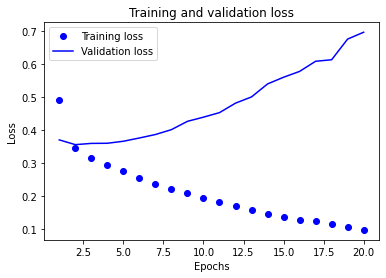

In [17]:
import matplotlib.pyplot as plt

acc = historyl_dict['accuracy']
val_acc = historyl_dict['val_accuracy']
loss = historyl_dict['loss']
val_loss = historyl_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

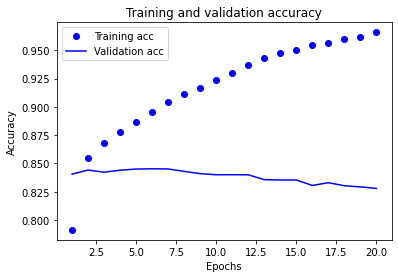

In [18]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

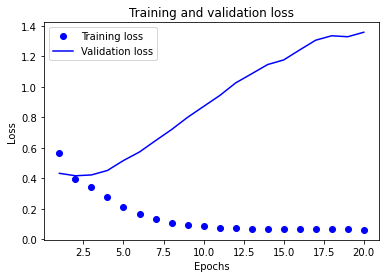

In [19]:
acc = historyc_dict['accuracy']
val_acc = historyc_dict['val_accuracy']
loss = historyc_dict['loss']
val_loss = historyc_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
acc = historyc_dict['accuracy']
val_acc = historyc_dict['val_accuracy']
loss = historyc_dict['loss']
val_loss = historyc_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

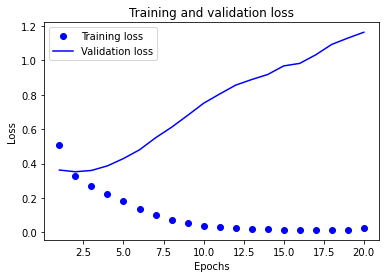

In [20]:
acc = historym_dict['accuracy']
val_acc = historym_dict['val_accuracy']
loss = historym_dict['loss']
val_loss = historym_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

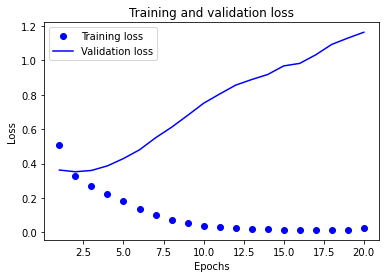

In [21]:
acc = historym_dict['accuracy']
val_acc = historym_dict['val_accuracy']
loss = historym_dict['loss']
val_loss = historym_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 7) 학습된 embedding 레이어 분석

In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# ko.model pre-train해보기

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv
vector.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [37]:
# embedding layer를 바꿔주기
index_to_word = {index:word for word, index in word_to_index.items()}
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

In [38]:
from tensorflow.keras.initializers import Constant

# 모델 구성

#모델1 : conv + globalmaxpool
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     input_length=48, 
                                     trainable=True))   # trainable을 True로 주면 Fine-tuning
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.MaxPooling1D(5))
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid')) 


In [39]:
#모델2 : lstm
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, 
                                     word_vector_dim, 
                                     embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                     input_length=48, 
                                     trainable=True))   # trainable을 True로 주면 Fine-tuning
model2.add(tf.keras.layers.LSTM(10))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(tf.keras.layers.Dense(10, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


In [40]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

print('-------------')

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
187/187 [==============================] - 2s 8ms/step - loss: 0.6659 - accuracy: 0.5855 - val_loss: 0.6033 - val_accuracy: 0.6745
Epoch 2/20
187/187 [==============================] - 1s 6ms/step - loss: 0.5591 - accuracy: 0.7118 - val_loss: 0.5302 - val_accuracy: 0.7308
Epoch 3/20
187/187 [==============================] - 1s 6ms/step - loss: 0.4939 - accuracy: 0.7580 - val_loss: 0.4986 - val_accuracy: 0.7538
Epoch 4/20
187/187 [==============================] - 1s 6ms/step - loss: 0.4539 - accuracy: 0.7832 - val_loss: 0.4719 - val_accuracy: 0.7687
Epoch 5/20
187/187 [==============================] - 1s 6ms/step - loss: 0.4235 - accuracy: 0.8010 - val_loss: 0.4614 - val_accuracy: 0.7750
Epoch 6/20
187/187 [==============================] - 1s 6ms/step - loss: 0.3982 - accuracy: 0.8146 - val_loss: 0.4519 - val_accuracy: 0.7814
Epoch 7/20
187/187 [==============================] - 1s 6ms/step - loss: 0.3795 - accuracy: 0.8253 - val_loss: 0.4553 - val_accuracy: 0.7830
Epoch 

In [42]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results1)
print(results2)

1527/1527 - 3s - loss: 0.6236 - accuracy: 0.7720
1527/1527 - 3s - loss: 0.4510 - accuracy: 0.8324
[0.6236186623573303, 0.7719643115997314]
[0.4510156214237213, 0.8323917388916016]


## 성능 개선 그래프 시각화

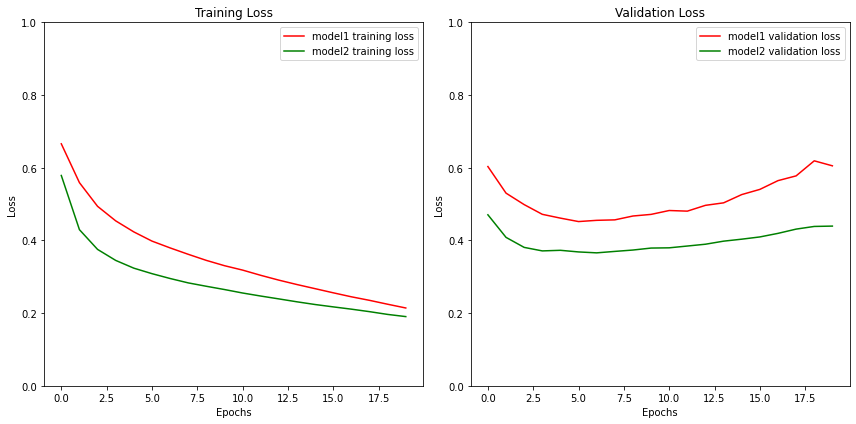

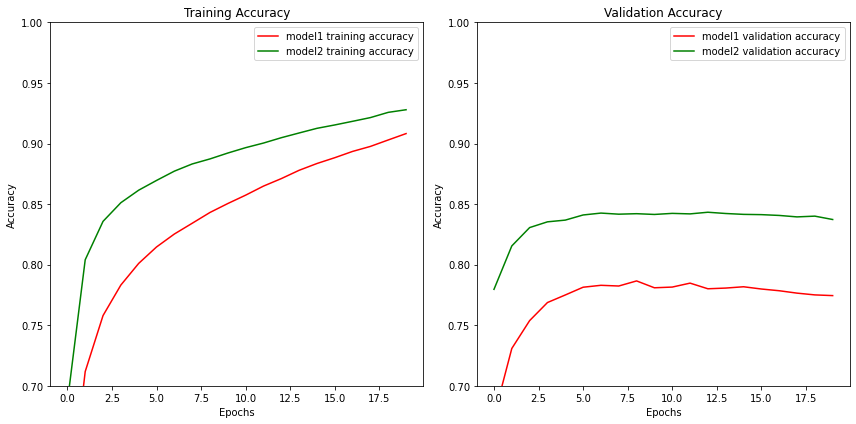

In [44]:
# 서브플롯을 사용하여 그래프 그리기
import matplotlib.pyplot as plt

# 훈련 손실 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], 'r', label='model1 training loss')
plt.plot(history2.history['loss'], 'g', label='model2 training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.0, 1.0)

# 검증 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], 'r', label='model1 validation loss')
plt.plot(history2.history['val_loss'], 'g', label='model2 validation loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.0, 1.0)

plt.tight_layout()
plt.show()

# 훈련 정확도 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], 'r', label='model1 training accuracy')
plt.plot(history2.history['accuracy'], 'g', label='model2 training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.7, 1.0)

# 검증 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history1.history['val_accuracy'], 'r', label='model1 validation accuracy')
plt.plot(history2.history['val_accuracy'], 'g', label='model2 validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.7, 1.0)

plt.tight_layout()
plt.show()

## 회고하기

1. 과적합을 방지할 만한 여러가지 기법을 사용해보면 좋을 것 같다.(어떤 방식으로 해야하는 지 모름.)
2. earlystopping을 통해 여러번의 에포크를 실험하기 보다 한 번에 확인하는 것이 필요할 것 같다.
3. train / val / test의 데이터의 분포를 잘 파악하여 나누는 방법에 대해 생각해 볼 필요가 있는 것 같다.